
  water:

       temperature             300  K
          pressure          100000  Pa
           density         996.633  kg/m^3
  mean mol. weight          18.016  amu
    vapor fraction               0

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy    -1.58581e+07       -2.857e+08     J
   internal energy    -1.58582e+07       -2.857e+08     J
           entropy         3913.18         7.05e+04     J/K
    Gibbs function    -1.70321e+07       -3.068e+08     J
 heat capacity c_p         4180.79        7.532e+04     J/K
 heat capacity c_v            4131        7.442e+04     J/K



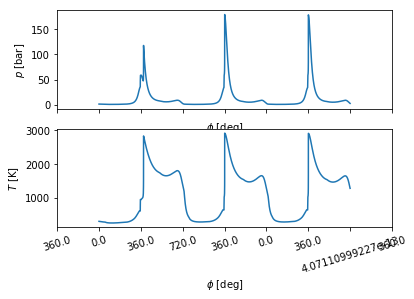

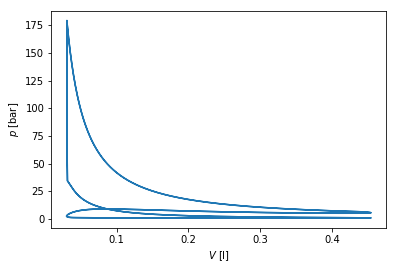

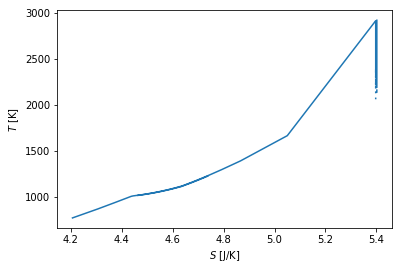

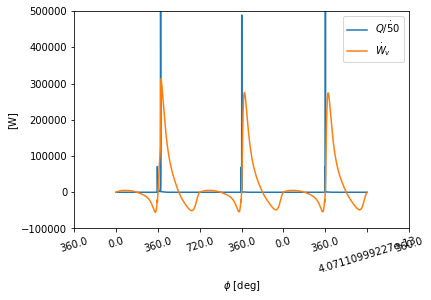

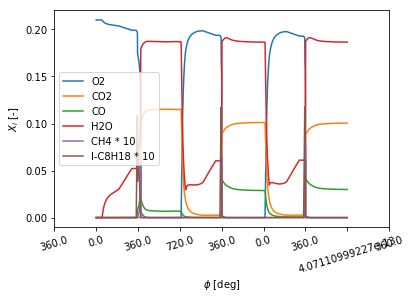

ValueError: No such species 'NO2'.

<Figure size 432x288 with 0 Axes>

In [13]:
import cantera as ct
import numpy as np
import csv

#geometria cylindra i pr obrotowa
omg = 3000. / 60.  # predkosc obrotowa walu [1/s] (3000 rpm)
h = 0.15 # skok [m]
epsilon = 15.4  # st sprezania [-]
d_tlok = 0.06  # srednica tloka [m]

A_tlok = np.pi * (d_tlok**2.)/4.
V_H = h * A_tlok  # poj skokowa cylindra [m**3]
V_g = V_H / (epsilon - 1.)


e_ign = 50. # energia iskry
T_iskra = 10000 #K

#wlot
T_wlot = 300. # K
P_wlot = 1.4e5 # Pa
sklad_wlot = 'O2:1, N2:3.76'

#wylot
P_wylot = 1.0e5 #Pa

#wtrysk paliwa 
T_f = 300. # K
P_f = 200.0e5 #Pa
sklad_f = 'I-C8H18:1' #benzyna: izooktan 
#sklad_f = 'N-C12H26:1' #olej: n-dodekan 

#wtrysk wody
T_w = 300.
P_w = 200.e5
#sklad_w = 'H2O:1'
#Q_w = 2.427e6 #J/kg - cieplo odparowania wody w 30'C

#otoczenie
P_ot = 300. # K

# wspolczynnik tarcia zaworu wlotowego, czas otwarcia i zamkniecia
wsp_wlot = 1.e-6
wlot_otw = -18. / 180. * np.pi
wlot_zam = 198. / 180. * np.pi

# wspolczynnik tarcia zaworu wylotowego, czas otwarcia i zamkniecia
wsp_wylot = 1.e-7
wylot_otw = 522. / 180 * np.pi
wylot_zam = 18. / 180. * np.pi

# masa paliwa, czas rozpoczecia i zakonczenia wtrysku
f_otw = 345. / 180. * np.pi
f_zam = 360. / 180. * np.pi
lbd = 0.847
V_pow = 0.44927e-3 #m3
nf = 1.1e5*V_pow/lbd/12.5/8.314/330/4.76 #benzyna
#nf = P_wlot*(V_g + V_H)/lbd/12.5/8.314/T_wlot/4.76 #benzyna
#nf = P_wlot*(V_g + V_H)*lbd/18.5/8.314/T_wlot/4.76 #olej
f_masa = nf*114/1000  # kg benzyna
#f_masa = nf*170/1000  # kg olej
f_czas_otw = (f_zam - f_otw) / 2. / np.pi / omg

# moment zaplonu
t_iskry = 355. / 180. *np.pi
t_konca_iskry = 356. / 180. *np.pi
iskra_czas = (t_konca_iskry - t_iskry)/2./np.pi/omg

# masa wody, czas rozpoczecia i zakonczenia wtrysku
kat_w_otw = 50.
w_otw = kat_w_otw / 180. * np.pi
#w_czas_otw = (100./ 180. * np.pi)/2./np.pi/omg
w_f = 0.5
w_masa = w_f * f_masa  # kg
T_parowania = ((840. - (355. - kat_w_otw)/2. *520./175.)+460.)/2. #K
wsp_parowania_650 = 0.0183*P_w/(1e5) + 0.375 #g/s
wsp_parowania = wsp_parowania_650 * (T_parowania -300.)/(650.-300.) #g/s
w_czas_otw = w_masa/(wsp_parowania/1000.)
w_zam = w_otw + w_czas_otw * 2 *np.pi*omg
w_masa_2 = 0.
w_zam_2 = t_iskry
w_czas_otw_2 = 1.
if (w_zam > t_iskry): #woda nie odparowala do zaplonu - wiekszy wsp parowania
    w_zam = t_iskry
    T_parowania_2 = (3130.+1550.)/2
    wsp_parowania_2 = wsp_parowania_650 * (T_parowania_2-300.)/(650.-300.) #g/s
    w_czas_otw = (w_zam - w_otw)/omg/2./np.pi
    w_masa_2 = w_masa - (wsp_parowania/1000. * w_czas_otw)
    w_masa = wsp_parowania/1000. * w_czas_otw
    w_czas_otw_2 = w_masa_2/(wsp_parowania_2/1000.)
    w_zam_2 = w_zam + w_czas_otw_2 * 2 * np.pi*omg
    print('woda odparowala podczas spalania')
    if(w_zam_2>wylot_otw): #woda nie odparowala do otwarcia wylotu - koniec wtrysku
        print ('woda nie odparowala calkowicie')
        w_czas_otw_2 = (wylot_otw - w_zam)/omg/2./np.pi
        w_masa_2 = w_czas_otw_2 * wsp_parowania_2/1000.
        w_zam_2 = wylot_otw
    
# czas symulacji i liczba obrotow
sim_obroty = 6.
sim_kroki = 12000.

# mechanizm reakcji
gas = ct.Solution('blanquart.cti')

# stan początkowy
gas.TPX = T_wlot, P_wlot, sklad_wlot
r = ct.IdealGasReactor(gas)
#wlot
wlot = ct.Reservoir(gas)
# wtrysk paliwa
gas.TPX = T_f, P_f, sklad_f
wtrysk_f = ct.Reservoir(gas)
#wtrysk wody
#gas.TPX = T_w, P_w, sklad_w
w = ct.PureFluid('liquidvapor.cti','water')
w.TP = T_w, 1.0e5
print (w.report())
wtrysk_w = ct.Reservoir(w)
# wylot (istotne tylko cisnienie)
gas.TPX = T_wlot, P_wylot, sklad_wlot
wylot = ct.Reservoir(gas)
# otoczenie (istotne tylko cisnienie)
gas.TPX = T_wlot, P_ot, sklad_wlot
otoczenie = ct.Reservoir(gas)
#swieca
gas.TPX = T_iskra, P_f, 'OH:1'
swieca = ct.Reservoir(gas)
gas.TPX = T_wlot, P_wylot, sklad_wlot

# granice cylindra
zaw_wlot = ct.Valve(wlot, r)
wtrysk_f_mfc = ct.MassFlowController(wtrysk_f, r)
zaw_wylot = ct.Valve(r, wylot)
tlok = ct.Wall(otoczenie, r)
iskra = ct.MassFlowController(swieca, r)
wtrysk_w_mfc = ct.MassFlowController(wtrysk_w, r)

#zamiana czasu na kat obrotu walu
def kat_walu(t):
    return np.remainder(2 * np.pi * omg * t, 4 * np.pi)
def kat_st(t):
    return np.remainder(360. * omg * t, 720.)
# parametry silnika
r.volume = V_g
tlok.area = A_tlok
def predkosc_tloka(t):
    return - h / 2 * 2 * np.pi * omg * np.sin(kat_walu(t))
tlok.set_velocity(predkosc_tloka)

sim = ct.ReactorNet([r])

# miejsce na wyniki
states = ct.SolutionArray(r.thermo)
t_sim = sim_obroty / omg
t = (np.arange(sim_kroki) + 1) / sim_kroki * t_sim
V = np.zeros_like(t)
m = np.zeros_like(t)
test = np.zeros_like(t)
mdot_in = np.zeros_like(t)
mdot_out = np.zeros_like(t)
d_W_v_d_t = np.zeros_like(t)
heat_release_rate = np.zeros_like(t)
T_max = T_wlot
p_max = P_wlot
                          
# parametry automatycznego koncowego porzadkowania
n_ost_porzadk = -np.inf  # tylko inicjalizacja
n_wait_coarsening = 10

with open('wyniki_tekst.csv','wb') as wyniki:
    csvfile = csv.writer(wyniki)
    csvfile.writerow(['h20/paliwo = %2.1f'%w_f,'poczatek wtrysku wody = %2.0f stopni'%kat_w_otw, 'stopien sprezania = %2.1f'%epsilon])
    csvfile.writerow(['wspolczynnik parowania = %2.1f'%wsp_parowania,'cisnienie wtrysku = %2.0f bar'%(P_w/1e5),'E iskry = %2.0f'%e_ign])
    #csvfile.writerow(['E iskry = %2.0f'%e_ign])
    if (w_zam > t_iskry):
        csvfile.writerow(['woda odparowala podczas spalania'])
    if (w_zam_2>wylot_otw):
        csvfile.writerow(['woda nie odparowala calkowicie'])
#csvfile.writerow(['masa iskry = %2.2f mg'%(masa_iskry * 1e6),'masa paliwa = %2.2f mg'%(f_masa * 1e6),
#                  'masa odparowanej wody = %2.4f mg'%((w_masa +w_masa_2)* 1e6),'czas parowania wody = %2.2f ms'%((w_czas_otw +w_czas_otw_2)/2./np.pi/3.)])
    csvfile.writerow(['n','phi [stopnie]','p [Pa]','V [m3]', 'T [K]'])
    
# symulacja
for n1, t_i in enumerate(t):
    # definicja otwarcia i zamkniecia zaworow
    if (np.mod(kat_walu(t_i) - wlot_otw, 4 * np.pi) <
            np.mod(wlot_zam - wlot_otw, 4 * np.pi)):
        zaw_wlot.set_valve_coeff(wsp_wlot)
        test[n1] = 1
    else:
        zaw_wlot.set_valve_coeff(0)
    if (np.mod(kat_walu(t_i) - wylot_otw, 4 * np.pi) <
            np.mod(wylot_zam - wylot_otw, 4 * np.pi)):
        zaw_wylot.set_valve_coeff(wsp_wylot)
    else:
        zaw_wylot.set_valve_coeff(0)
    if (np.mod(kat_walu(t_i) - f_otw, 4 * np.pi) <
            np.mod(f_zam - f_otw, 4 * np.pi)):
        wtrysk_f_mfc.set_mass_flow_rate(f_masa / f_czas_otw)
    else:
        wtrysk_f_mfc.set_mass_flow_rate(0)
    if (np.mod(kat_walu(t_i) - w_otw, 4 * np.pi) <
            np.mod(w_zam - w_otw, 4 * np.pi)):
        wtrysk_w_mfc.set_mass_flow_rate(w_masa / w_czas_otw)
        #tlok.set_heat_flux(Q_w * w_masa/w_czas_otw)
        
    if (np.mod(kat_walu(t_i) - w_zam, 4 * np.pi) <
            np.mod(w_zam_2 - w_zam, 4 * np.pi)):
        wtrysk_w_mfc.set_mass_flow_rate(w_masa_2 / w_czas_otw_2)
    
    if (np.mod(kat_walu(t_i) - w_otw, 4 * np.pi) >
            np.mod(w_zam_2 - w_otw, 4 * np.pi)):
        wtrysk_w_mfc.set_mass_flow_rate(0.)

#    else:
#        wtrysk_w_mfc.set_mass_flow_rate(0.)
#        #tlok.set_heat_flux(0)
        
    if (np.mod(kat_walu(t_i) - t_iskry, 4 * np.pi) <
            np.mod(t_konca_iskry - t_iskry, 4 * np.pi)):
        deltaT = T_iskra - r.thermo.T
        masa_iskry = e_ign/swieca.thermo.cp_mass/deltaT
        iskra.set_mass_flow_rate(masa_iskry / iskra_czas)
    else:
        iskra.set_mass_flow_rate(0.)
        
    #if (r.thermo.T>T_max):
    #    T_max = r.thermo.T
    if (r.thermo.P>p_max):
        p_max = r.thermo.P

    
#    div_n = float(n1/10.)
#    with open('wyniki_tekst.csv','ab') as wyniki:
#        csvfile = csv.writer(wyniki)
#        if (div_n.is_integer() is True):
#            csvfile.writerow(['%s'%n1,'%2.2f'%kat_st(t_i),'%2.0f'%r.thermo.P,'%1.8f'%r.volume,'%2.2f'%r.thermo.T])

    # perform time integration, refine time step if necessary
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            sim.advance(t_i)
        except Exception:
            sim.set_max_time_step(1e-6 * 10. ** -n2)
            n_ost_porzadk = n1
    # coarsen time step if too long ago
    if n1 - n_ost_porzadk is n_wait_coarsening:
        sim.set_max_time_step(1e-5)
 
         # write output data
    states.append(r.thermo.state)
    V[n1] = r.volume
    m[n1] = r.mass
    mdot_in[n1] = zaw_wlot.mdot(0)
    mdot_out[n1] = zaw_wylot.mdot(0)
    d_W_v_d_t[n1] = - (r.thermo.P - otoczenie.thermo.P) * A_tlok * \
       predkosc_tloka(t_i)
    heat_release_rate[n1] = - r.volume * ct.gas_constant * r.T * \
       np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)
    

            
#####################################################################
# Plot Results in matplotlib
#####################################################################

import matplotlib.pyplot as plt

# pressure and temperature
plt.clf()
plt.subplot(211)
plt.plot(t, states.P / 1.e5)
plt.ylabel('$p$ [bar]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], [])
plt.subplot(212)
plt.plot(t, states.T)
plt.ylabel('$T$ [K]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], kat_walu(plt.xticks()[0]) * 180 / np.pi,
           rotation=17)
plt.show()
plt.savefig('ic_engine_t_p_T.png')

# p-V diagram
plt.clf()
plt.plot(V[t > 0.04] * 1000, states.P[t > 0.04] / 1.e5)
plt.xlabel('$V$ [l]')
plt.ylabel('$p$ [bar]')
plt.show()
plt.savefig('ic_engine_p_V.png')

# T-S diagram
plt.clf()
plt.plot(m[t > 0.04] * states.s[t > 0.04], states.T[t > 0.04])
plt.xlabel('$S$ [J/K]')
plt.ylabel('$T$ [K]')
plt.show()
plt.savefig('ic_engine_T_S.png')

# heat of reaction and expansion work
plt.clf()
plt.plot(t, heat_release_rate/50., label='$\dot{Q/50}$')
plt.plot(t, d_W_v_d_t, label='$\dot{W}_v$')
plt.ylim(-1e5, 5.e5)
plt.legend(loc=0)
plt.ylabel('[W]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], kat_walu(plt.xticks()[0]) * 180 / np.pi,
           rotation=17)
plt.show()
plt.savefig('ic_engine_Q_W.png')

# gas composition
plt.clf()
plt.plot(t, states('O2').X, label='O2')
plt.plot(t, states('CO2').X, label='CO2')
plt.plot(t, states('CO').X, label='CO')
plt.plot(t, states('H2O').X, label='H2O')
plt.plot(t, states('CH4').X *10, label='CH4 * 10')

plt.plot(t, states('I-C8H18').X *10 , label='I-C8H18 * 10') #benzyna
#plt.plot(t, states('N-C12H26').X *10 , label='N-C12H26 * 10') #olej
plt.legend(loc=0)
plt.ylabel('$X_i$ [-]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], kat_walu(plt.xticks()[0]) * 180 / np.pi,
           rotation=17)
plt.show()
plt.savefig('ic_engine_t_X.png')



#####################################################################
# Integral Results
#####################################################################
with open('wyniki_tekst.csv','ab') as wyniki:
    csvfile = csv.writer(wyniki)
    csvfile.writerow(states('NO2').X)

from scipy.integrate import trapz
Q = trapz(heat_release_rate, t)
W = trapz(d_W_v_d_t, t)
Qt = Q + W
eta = W / Qt
MW = states.mean_molecular_weight
CO_emission = trapz(MW * mdot_out * states('CO').X[:,0], t) / trapz(MW * mdot_out, t)
print('Heat release rate per cylinder (estimate):\t' +
      format(Q / t_sim / 1000., ' 2.1f') + ' kW')
print('Expansion power per cylinder (estimate):\t' +
      format(W / t_sim / 1000., ' 2.1f') + ' kW')
print('Efficiency (estimate):\t\t\t' + format(eta * 100., ' 2.1f') + ' %')
print('CO emission (estimate):\t\t' + format(CO_emission * 1.e6, ' 2.1f') +
      ' ppm')
print('Qt:\t' + format(Qt/t_sim/1000., ' 2.1f') +
      ' kW')
print('masa iskry = \t'+ format(masa_iskry * 1e6, '2.2f') + 'mg')
print('masa wtrysnietego paliwa = \t'+ format(f_masa * 1e6, '2.2f') + 'mg')
#print('masa odparowanej wody = \t'+ format((w_masa) * 1e6, '2.2f') + 'mg')
print('masa odparowanej wody = \t'+ format((w_masa+w_masa_2) * 1e6, '2.2f') + 'mg')
#print('czas parowania wody = \t'+ format((w_czas_otw)/2./np.pi/3., '2.4f') + 'ms')
print('czas parowania wody = \t'+ format((w_czas_otw+w_czas_otw_2)/2./np.pi/3., '2.4f') + 'ms')
#print('temperatura maksymalna = \t' + format(T_max,'4.0f')+'K')
print('ciśnienie maksymalne = \t' + format(p_max/1e5,'3.2f')+'bar')
with open('wyniki_tekst.csv','ab') as wyniki:
    csvfile = csv.writer(wyniki)
    csvfile.writerow(['masa iskry = %2.2f mg'%(masa_iskry * 1e6),'masa paliwa = %2.2f mg'%(f_masa * 1e6),
                      'masa odparowanej wody = %2.4f mg'%((w_masa +w_masa_2)* 1e6),'czas parowania wody = %2.2f ms'%((w_czas_otw +w_czas_otw_2)/2./np.pi/3.)])
#    csvfile.writerow(['masa iskry = %2.2f mg'%(masa_iskry * 1e6),'masa paliwa = %2.2f mg'%(f_masa * 1e6),
#                      'masa odparowanej wody = %2.4f mg'%((w_masa)* 1e6),'czas parowania wody = %2.2f ms'%((w_czas_otw)/2./np.pi/3.)])
    csvfile.writerow(['p max = %3.2f bar'%(p_max/1e5),'Q = %2.2f kW'%(Q/t_sim/1000.),'W = %2.2f kW'%(W/t_sim/1000.),'eta= %2.2f'%(eta*100.), 'Q+W = %2.2f'%((Q+W)/t_sim/1000.)])
wyniki.close()